### Solutions to the sets of exercises in the notebooks

### 1. Downloading images from the SDSS for given a region on the sky

In [ ]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
import numpy as np

from astropy.visualization import make_lupton_rgb, ImageNormalize
import matplotlib.pyplot as plt
import reproject
import astropy.io.fits as fits

In [ ]:
#define region using SkyCoord
pos = coords.SkyCoord(229.0128, -0.1082, unit="deg")
res = SDSS.query_region(pos, radius="0.001 deg", timeout=3600)
#access images
images = SDSS.get_images(matches=res)

#### Format of list
Images are returned as a list of lists. A list of images with each entry in the list containing a list of fits HDU data structures

In [ ]:
print (images[0])

In [ ]:
# Display images using imshow()
from matplotlib.colors import LogNorm
plt.imshow(images[0][0].data,  cmap='gray', vmin=-1., vmax=1.)
print('Min:', np.min(images[0][0].data))
print('Max:', np.max(images[0][0].data))
print('Mean:', np.mean(images[0][0].data))
print('Stdev:', np.std(images[0][0].data))

####  You could display the images as a color image

```rgb_img = make_lupton_rgb(ImageNormalize(vmin=0, vmax=1)(red['SCI'].data),
                          ImageNormalize(vmin=0, vmax=0.3)(green_repr),
                          ImageNormalize(vmin=0, vmax=1)(blue_repr),
                          stretch=0.1,
                          minimum=0,
                         )
```


### 2.  Using astroquery to search for high redshift QSOs (z>4.5) by selecting star like sources from the SDSS

Usually we use a mix of infrared and optical colors to find high redshift QSOs
- Given a region on the sky find all star like sources within 10 arcmins of 00h07m49.17", "+00d41m19.61s
- Cross match the data against the WISE infrared catalog (the name of this catalog is "vizier:ii/328/allwise"
- Select QSOs as star like sources with z-W1 > 2.5 and W1 - W2 >0.4
- Plot the stars and QSO candidates
- Match you QSOs with the "" catalog of high redshift QSOs and see if you found any

Our target of interest is the QSO J000749.17+004119.61

In [2]:
#translate the position into degrees with SkyCoord
from astroquery.sdss import SDSS
from astropy import coordinates as coords

pos = coords.SkyCoord("00h07m49.17", "+00d41m19.61s")

/Users/ajc/miniconda3/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [3]:
pos

<SkyCoord (ICRS): (ra, dec) in deg
    (1.954875, 0.68878056)>

In [4]:
#use the fGetNearbyObjEq function to find sources near the postion 
#and join them with SDSS stars
query = """
SELECT
  s.ra, s.dec,
  s.psfMag_g as g, s.psfMag_r as r, s.psfMag_i as i, s.psfMag_z as z
  
FROM
  dbo.fGetNearbyObjEq(1.954875, 0.68878056, 10) AS n
  JOIN Star AS s ON n.objID = s.objID
"""
res = SDSS.query_sql(query, timeout=3600)


In [5]:
res[:2]

ra,dec,g,r,i,z
float64,float64,float64,float64,float64,float64
1.86478041993462,0.731325001090232,22.89716,22.18872,21.7882,21.18226
1.8719840318696,0.633437605237077,23.75432,22.93134,23.27887,21.77752


In [6]:
res.write("pos_list.csv", overwrite=True)

Text(0,0.5,'i-z')

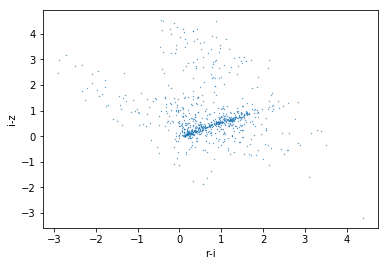

In [7]:
#plot the colors to see the stellar locus
import matplotlib.pyplot as plt
%matplotlib inline
mask = res['g']> 0
ri = res['r'][mask] - res['i'][mask]
iz = res['i'][mask] - res['z'][mask]
plt.scatter(ri,iz, s=0.1)
plt.xlabel('r-i')
plt.ylabel('i-z')

In [45]:
#cross match with WISE using XMatch
from astropy import units as u
from astroquery.xmatch import XMatch

In [46]:
table = XMatch.query(cat1=open('pos_list.csv'),
                     cat2='vizier:ii/328/allwise',
                     max_distance=3 * u.arcsec, colRA1='ra',colDec1='dec')

In [48]:
#zw1[table['AllWISE'] == 'J000749.13+004119.5']
table[:2]

angDist,ra,dec,g,r,i,z,AllWISE,RAJ2000,DEJ2000,eeMaj,eeMin,eePA,W1mag,W2mag,W3mag,W4mag,Jmag,Hmag,Kmag,e_W1mag,e_W2mag,e_W3mag,e_W4mag,e_Jmag,e_Hmag,e_Kmag,ID,ccf,ex,var,qph,pmRA,e_pmRA,pmDE,e_pmDE,d2M
float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str4,int64,str4,str4,int64,int64,int64,int64,float64
0.087519,1.95797642190703,0.589054809937545,17.32394,16.60721,16.33525,16.13513,J000749.91+003520.6,1.9579695,0.5890781,0.0736,0.0702,148.1,14.471,14.524,12.428,8.83,15.148,14.563,14.574,0.03,0.06,--,--,0.044,0.053,0.077,15100001351054747,0000,0,11nn,AAUU,90,180,139,182,0.188
0.252099,2.05379195935495,0.708218086716404,22.47246,21.18676,19.88708,19.25394,J000812.89+004229.4,2.053739,0.7081723,0.3568,0.3275,130.8,16.938,16.355,12.468,8.725,--,--,--,0.116,0.274,--,--,--,--,--,15100001351052787,0000,0,0nnn,BBUU,-1242,1473,21,1491,--


Text(0,0.5,'W1-W2')

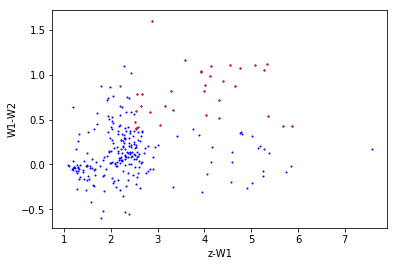

In [49]:
#replot the colors with infrared WISE data
zw1 = table['z'] - table['W1mag']
w1w2 = table['W1mag'] - table['W2mag']
plt.scatter(zw1,w1w2, s=1, c='b')
plt.scatter(zw1[((zw1>2.5) & (w1w2 > 0.4))],w1w2[((zw1>2.5) & (w1w2 > 0.4))], s=1, c='r')
#plt.scatter(zw1[table['AllWISE'] == 'J000749.13+004119.5'],w1w2[table['AllWISE'] == 'J000749.13+004119.5'], s=5, c='g')
#print (zw1[table['AllWISE'] == 'J000749.13+004119.5'],w1w2[table['AllWISE'] == 'J000749.13+004119.5'])
plt.xlabel('z-W1')
plt.ylabel('W1-W2')

In [50]:
#select the subset of sources and Xmatch with the milliquas dataset 
#on vizier to find the redshifts
selection = ((table['z'] - table['W1mag'] > 2.5) & (table['W1mag'] - table['W2mag'] > 0.4))
selectedTable = table[selection].copy()

In [51]:
selectedTable['ra','dec'].write("test.dat", format='ascii.csv',overwrite=True)

In [52]:
table2 = XMatch.query(cat1=open('test.dat'),
                     cat2='vizier:VII/280/catalog',
                     max_distance=1 * u.arcsec,
                     colRA1='ra', colDec1='dec')
table2

angDist,ra,dec,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,Name,Cl,A,Rmag,Bmag,Com,R,B,z,Qpct,XName,RName
float64,float64,float64,float64,float64,float64,float64,str24,str1,str1,float64,float64,str2,float64,float64,float64,int64,str22,int64
0.000933,1.85353307393029,0.67238524853914,1.853533,0.672385,1.853533,0.672385,SDSS J000724.84+004020.5,Q,--,22.21,22.27,g,-1.0,-1.0,2.148,--,--,--
0.044698,1.85492815769283,0.61251956959154,1.854938,0.612512,1.854938,0.612512,SDSS J000725.18+003645.0,Q,--,18.92,19.64,p,-1.0,-1.0,2.033,--,--,--
0.001154,1.95486686382537,0.688780290276984,1.954867,0.68878,1.954867,0.68878,SDSS J000749.16+004119.6,Q,--,21.48,24.6,g,-1.0,-1.0,4.78,--,--,--
0.038623,2.06534661116746,0.754488768868597,2.065337,0.754484,2.065337,0.754484,SDSS J000815.68+004516.1,Q,X,19.5,20.29,pm,-1.0,-1.0,1.093,98,1SXPS J000815.5+004513,--
0.067142,2.00719260101971,0.770383380331255,2.007174,0.770382,2.007174,0.770382,SDSS J000801.72+004613.3,Q,--,20.03,21.41,p,-1.0,-1.0,1.916,--,--,--
0.001211,2.10335011977531,0.659427314394134,2.10335,0.659427,2.10335,0.659427,SDSS J000824.80+003933.9,q,--,21.83,22.53,g,-1.0,-1.0,0.3,99,--,--
0.000536,1.79975608882398,0.667689880506845,1.799756,0.66769,1.799756,0.66769,SDSS J000711.94+004003.6,Q,X,20.99,21.31,g,-1.0,-1.0,1.533,73,1SXPS J000711.6+004003,--


In [ ]:
#see what tables
tabs = XMatch.get_available_tables()

In [ ]:
for tab in tabs:
    if ('VII/280' in tab):
        print (tab)

In [ ]:
J000749.17+004119.61

### 3. Fit a model to a data set and estimate the number of polynomial terms in the fit 

Increase the number of terms and then calculate the rms for a second sample of data

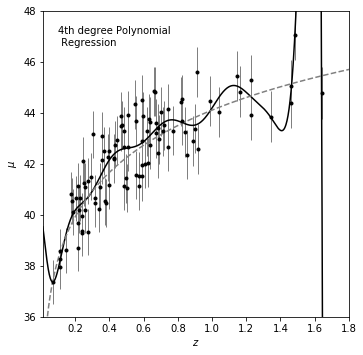

In [35]:
#fit the data using polynomials
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from astropy import cosmology
from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression


# fit multiple terms
from astroML.linear_model import PolynomialRegression

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = cosmology.FlatLambdaCDM(71, 0.27, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

# Define our classifiers
text = ['4th degree Polynomial\n Regression']

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0.1, right=0.95,
                    bottom=0.1, top=0.95,
                    hspace=0.05, wspace=0.05)


ax = fig.add_subplot(111)

# fit the data
degree = 15
clf = PolynomialRegression(degree=degree)
clf.fit(z_sample[:, None], mu_sample, dmu)

mu_sample_fit = clf.predict(z_sample[:, None])
mu_fit = clf.predict(z[:, None])

ax.plot(z, mu_fit, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)
ax.text(0.05, 0.95, text[0], ha='left', va='top', transform=ax.transAxes)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

In [55]:
# Estimate the rms for the fit
def rmsSample (sample1, sample2):
    '''Given two samples calculate the RMS'''
    return np.sqrt(((sample1-sample2)**2).sum()/len(sample1))

#fit model for initial sample used to fit the model
mu_sample_fit = clf.predict(z_sample[:, None])
print ("Train model", rmsSample(mu_sample_fit, mu_sample))


#draw another sample and fit to the model
z_sample2, mu_sample2, dmu2 = generate_mu_z(100, random_state=1)
mu_sample_fit2 = clf.predict(z_sample2[:, None])

print ("Test model", rmsSample(mu_sample_fit2, mu_sample2))

Train model 0.8843390633879045
Test model 2.483894974130676


### 4. GMM for estimating Star - Galaxy separation

Use a GMM to estimate the density of stars and galaxies

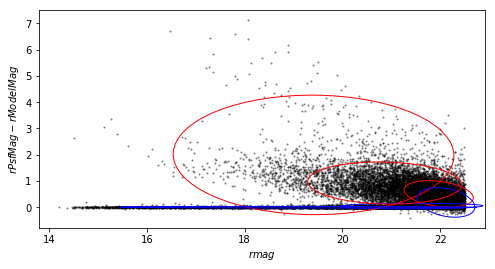

In [37]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from astroML.datasets import fetch_imaging_sample

from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# get data: returns data and classification (0:star / 1:RR Lyrae)
# data are u-g, g-r, r-i, i-z
#X, y = fetch_rrlyrae_combined()
# get data: returns data and classification (0:star / 1:galaxy)

def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()
    objtype = data['type']
    stars = data[objtype == 6][:Nstars]
    galaxies = data[objtype == 3][:Ngals]
    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])


data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))

n_components = 3

clfGalaxies = GaussianMixture(n_components, max_iter=100, 
                          init_params='random', random_state=10)
clfStars = GaussianMixture(n_components, max_iter=100, 
                          init_params='random', random_state=10)


# Fit galaxies
clfGalaxies.fit(X[:, [0, 1]][y==1])
clfStars.fit(X[:, [0, 1]][y==0])

# Plot results
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

ax.scatter(X[:,[0]], X[:,[1]], c='k', s=4, alpha=0.5, lw=0, cmap=plt.cm.binary)
xlim = (15., 22.5)
ylim = (-0.5, 5.)
ax.set_xlabel('$r mag$')
ax.set_ylabel('$rPsfMag - rModelMag$')

# plot the components
for i in range(clfGalaxies.n_components):
    draw_ellipse(clfGalaxies.means_[i], clfGalaxies.covariances_[i], ax=ax, fc='none', ec='r', zorder=2, scales=[2])
    draw_ellipse(clfStars.means_[i], clfStars.covariances_[i], ax=ax, fc='none', ec='b', zorder=2, scales=[2])



### 5. Use GMM to estimate the pobability of a star or galaxy as a function of magnitude difference

Use a GMM to estimate the density of stars and galaxies

Use the ratio of these densities to classify stars and galaxies

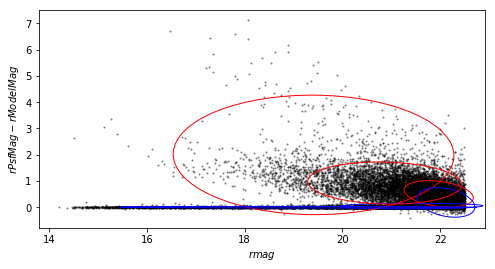

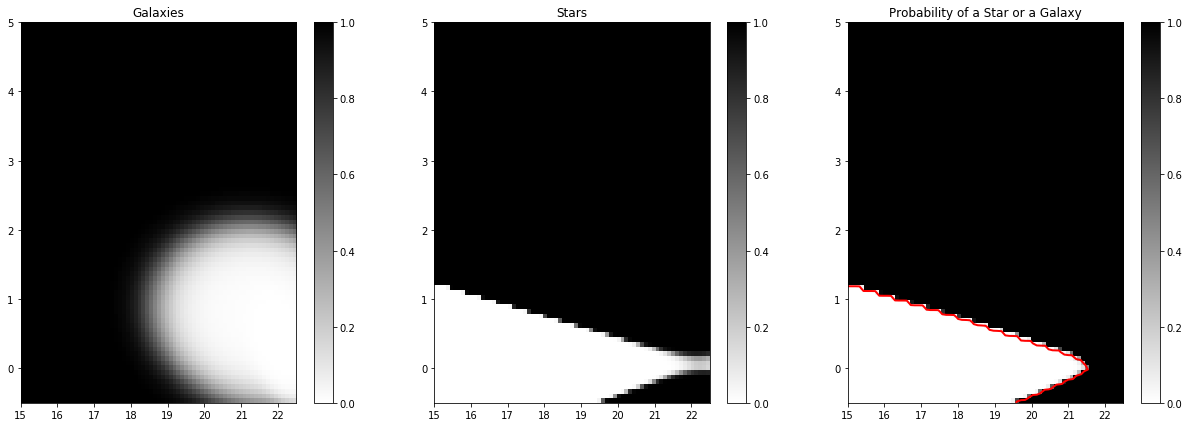

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

from astroML.datasets import fetch_imaging_sample

from sklearn.mixture import GaussianMixture
from astroML.plotting.tools import draw_ellipse

#----------------------------------------------------------------------
# get data: returns data and classification (0:star / 1:RR Lyrae)
# data are u-g, g-r, r-i, i-z
#X, y = fetch_rrlyrae_combined()
# get data: returns data and classification (0:star / 1:galaxy)

def get_stars_and_galaxies(Nstars=10000, Ngals=10000):
    """Get the subset of star/galaxy data to plot"""
    data = fetch_imaging_sample()
    objtype = data['type']
    stars = data[objtype == 6][:Nstars]
    galaxies = data[objtype == 3][:Ngals]
    return np.concatenate([stars,galaxies]), np.concatenate([np.zeros(len(stars)),np.ones(len(galaxies))])


data, y = get_stars_and_galaxies(Nstars=10000, Ngals=10000)

# select r model mag and psf - model mag as columns
X = np.column_stack((data['rRaw'], data['rRawPSF'] - data['rRaw']))

n_components = 3

# calculate the density for the stars and galaxies separately
clfGalaxies = GaussianMixture(n_components, max_iter=100, 
                          init_params='random', random_state=10)
clfStars = GaussianMixture(n_components, max_iter=100, 
                          init_params='random', random_state=10)


# Fit galaxies given each class
clfGalaxies.fit(X[:, [0, 1]][y==1])
clfStars.fit(X[:, [0, 1]][y==0])

# Plot results
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)

ax.scatter(X[:,[0]], X[:,[1]], c='k', s=4, alpha=0.5, lw=0, cmap=plt.cm.binary)
xlim = (15., 22.5)
ylim = (-0.5, 5.)
ax.set_xlabel('$r mag$')
ax.set_ylabel('$rPsfMag - rModelMag$')

# plot the components
for i in range(clfGalaxies.n_components):
    draw_ellipse(clfGalaxies.means_[i], clfGalaxies.covariances_[i], ax=ax, fc='none', ec='r', zorder=2, scales=[2])
    draw_ellipse(clfStars.means_[i], clfStars.covariances_[i], ax=ax, fc='none', ec='b', zorder=2, scales=[2])
   

# plot the relative densities for Galaxies and Stars using meshgrid to estimate densities
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71),
                     np.linspace(ylim[0], ylim[1], 81))
G = clfGalaxies.predict_proba(np.c_[xx.ravel(), yy.ravel()])
G = G[:, 1].reshape(xx.shape)
S = clfStars.predict_proba(np.c_[xx.ravel(), yy.ravel()])
S = S[:, 1].reshape(xx.shape)

fig = plt.figure(figsize=(21,7))
ax = fig.add_subplot(131)
im = ax.imshow(G, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.)
ax.set_title('Galaxies')
plt.colorbar(im)

ax = fig.add_subplot(132)
im = ax.imshow(S, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
im.set_clim(0, 1.)
ax.set_title('Stars')
plt.colorbar(im)

ax = fig.add_subplot(133)
prob = S/G
im = ax.imshow(prob, origin='lower', aspect='auto',
               cmap=plt.cm.binary, zorder=1,
               extent=xlim + ylim)
ax.contour(xx, yy, prob, [0.5], linewidths=2., colors='red')
im.set_clim(0, 1.)
ax.set_title('Probability of a Star or a Galaxy')
plt.colorbar(im)